# Mixture of Gaussians

**Sources:** <p>
<https://scikit-learn.org/stable/modules/mixture.html> <br/>
<https://www.youtube.com/watch?v=qMTuMa86NzU> <br/>
<https://www.youtube.com/watch?v=Rkl30Fr2S38&list=PLD0F06AA0D2E8FFBA&index=120&t=0s>
        
A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

Linear superposition of gaussians formulated as probabilistic models.
<img style="float: left;" src="images/mixture_gaussians_example.png" alt="drawing" width="250"/>
Superposition of $K$ Gaussian densities of the form:
$p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x} | \mu_k, \Sigma_k)$

Each Gaussian density $ \mathcal{N}(\mathbf{x} | \mu_k, \Sigma_k)$ is called a component of the mixture and has its own mean $\mu_k$ and covariance $\Sigma_k$. The parameters $\pi_k$ are called *mixing coefficitents*.

Optimized using EM. Can be seen and formulated as a generative process.

#### First load the libraries of interest.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn import mixture
import numpy as np
from scipy import stats
from scipy.stats import norm, percentileofscore
import itertools
import os

from utils.pre_processing import normalize_image
import scipy

#### Define auxiliary functions

In [3]:
def get_normal_pdf(x, mu, sigma):
    pdf = (1/np.sqrt(2*np.pi*sigma)) * np.exp(-(x-mu)**2/(2*sigma))
    return pdf

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

#### Paths to images of interest (T1, 2 scanner types first, along with brain masks)

In [4]:
t1_path = '/secure-data/scientific/interscanner/datasets/OASIS1/Processed/OAS1_0002_MR1/T1_neck_stripped_mni.nii.gz'
mask_path = '/secure-data/scientific/interscanner/datasets/OASIS1/Processed/OAS1_0002_MR1/brain_mask_mni.nii.gz'

#### Load the images and get the data

In [5]:
t1 = nib.load(t1_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

### Normalize image

In [6]:
t1_normalized = normalize_image(t1, clip_percentiles=False, pmin=0.1, pmax=99.9)

masked_image = t1_normalized * mask
data_slice = masked_image[:,:,int(np.shape(masked_image)[2]/2)]


In [7]:
t1.shape[1]//2

108

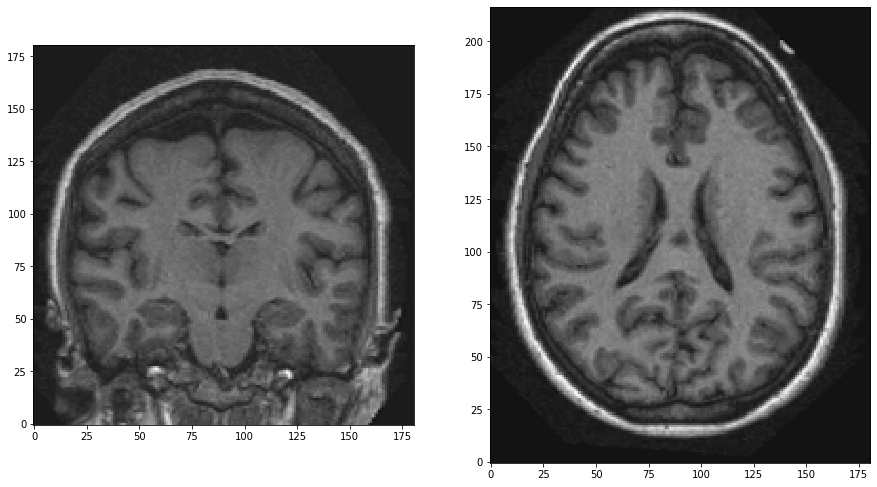

In [8]:
fig, ax = plt.subplots(1,2,figsize=(15,10))

ax[0].imshow(t1_normalized[:,t1_normalized.shape[1]//2,:].T, cmap="gray", origin="lower", vmin=0, vmax=1)

ax[1].imshow(t1_normalized[:,:,90].T, cmap="gray", origin="lower")


## Fit the gaussian mixture model

In [9]:
data_flat = masked_image[masked_image>0]

X=np.expand_dims(data_flat,1)
n_components=3

gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='diag', tol=1e-3, verbose=True)
xx = gmm.fit_predict(X)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True


In [10]:
data_flat.max()

0.7601964552637198

In [11]:
# Evaluate GMM
my_x = np.linspace(0,masked_image.max(), 200)
gmm_y_mr1 = np.exp(gmm.score_samples(my_x.reshape(-1,1)))

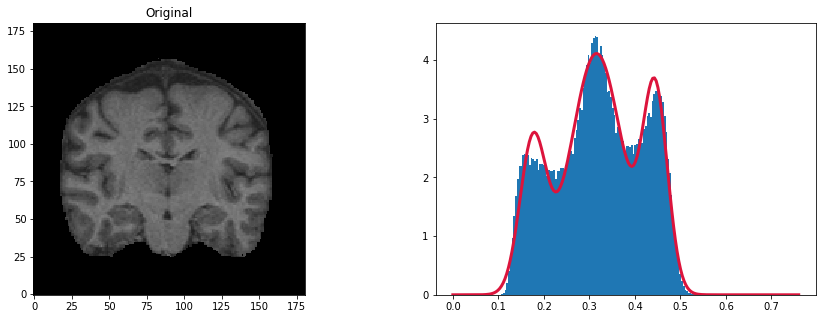

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].imshow(masked_image[:,masked_image.shape[1]//2,:].T, cmap="gray", origin="lower", vmin=0, vmax=1)
ax[0].set_title('Original')

# ax[1].hist(masked_image[masked_image>0].ravel(), 200, [0, 0.5], density=True);

# fig, ax = plt.subplots()
ax[1].hist(data_flat.ravel(),200,[0,masked_image.max()], density=True)
ax[1].plot(my_x, gmm_y_mr1, color="crimson", lw=3, label="GMM")

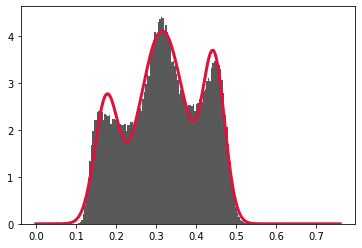

In [13]:
plt.hist(data_flat.ravel(),200,[0,masked_image.max()], density=True, facecolor='k', alpha=0.65)
plt.plot(my_x, gmm_y_mr1, color="crimson", lw=3, label="GMM")
# plt.grid(True)

#### Access the component parameters (means, variances and weights)

In [14]:
comp_means = gmm.means_[:,0]
comp_covs = gmm.covariances_[:,0] #.T[0,:]
comp_weights = gmm.weights_

In [15]:
# mu = comp_means
# std = np.sqrt(comp_covs)

sort_indices = comp_means.argsort(axis=0)
mu = comp_means[sort_indices]
std = np.sqrt(comp_covs)[sort_indices]
comp_weights = comp_weights[sort_indices]

In [16]:
print(mu, std)

[0.17591725 0.31573326 0.44479773] [0.02880612 0.05694722 0.02720033]


#### Estimate the posterior probabilities

In [17]:
probas_original = gmm.predict_proba(X=np.expand_dims(data_flat,1))
probas_original = probas_original[:, sort_indices]

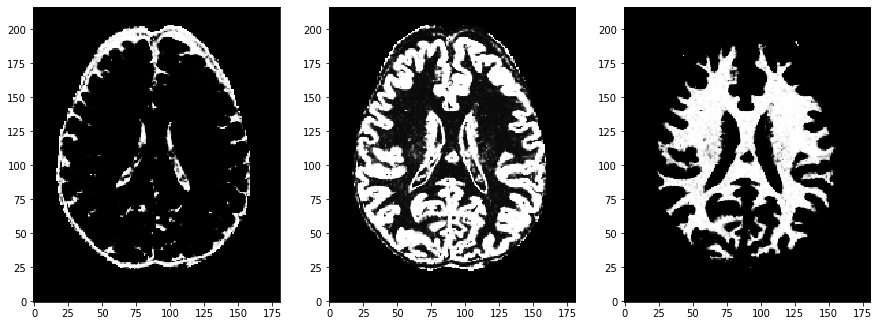

In [18]:
n_classes = n_components
fig, ax = plt.subplots(1,n_classes, figsize=(15,8))
for k in range(n_classes):
    new_img = np.zeros(masked_image.shape)
    new_img[np.where(masked_image>0)] = probas_original[:, k]
    ax[k].imshow(new_img[:,:,90].T, origin='lower', cmap='gray')

We can add some noise or smooth these maps

In [19]:
# dice_toss = np.random.randint(0,3)
# dise_toss=2
# print(dice_toss)
# if dice_toss == 0:
#     noise_level = np.random.uniform(0.1, 1)
#     print(noise_level)
#     # noise multiplied by bottom and top half images,
#     # whites stay white blacks black, noise is added to center
#     noise = np.random.normal(loc=0.2, scale=0.5, size=probas_original.shape)
#     img2 = probas_original * 2
#     probas_changed = np.clip(np.where(img2 <= 1, (img2*(1 + noise*noise_level)), 
#                                     (1-img2+1)*(1 + noise*noise_level)*-1 + 2)/2, 0,1)
# elif dice_toss == 1:
#     sigma = np.random.uniform(.5, 2)
#     print(sigma)
#     probas_changed = np.clip(gaussian(probas_original, sigma=sigma, 
#                         output=None, mode='nearest', cval=0,
#                         multichannel=True, preserve_range=True, truncate=3.0), 0,1)
# elif dice_toss == 2:
#     probas_changed = probas_original


In [20]:
probas_changed = probas_original


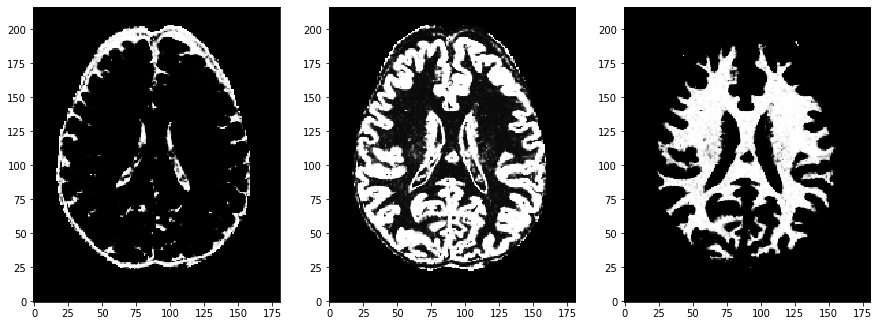

In [21]:
n_classes = n_components
fig, ax = plt.subplots(1,n_classes, figsize=(15,8))
for k in range(n_classes):
    new_img = np.zeros(masked_image.shape)
    new_img[np.where(masked_image>0)] = probas_changed[:, k]
    ax[k].imshow(new_img[:,:,90].T, origin='lower', cmap='gray')

we can plot the components for reference

In [22]:
original_intesities = np.unique(masked_image)
x = np.linspace(0,masked_image.max(),original_intesities.shape[0])

In [23]:
n_classes = n_components
comps = np.zeros(((n_components,) + x.shape))
for k in range(n_classes):
    comps[k] = norm.pdf(x, loc=mu[k], scale=std[k])
    
# complete_pdf = comp_weights.dot(comps)

complete_pdf = np.exp(gmm.score_samples(x.reshape(-1,1)))

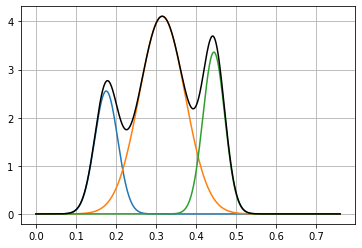

In [24]:
for ii in range(n_components):
    plt.plot(x, comps[ii] *  comp_weights[ii])
    
plt.grid()
plt.plot(x,complete_pdf, 'k')

# plt.plot(x,  comps[0] *  comp_weights[0] +  comps[1] *  comp_weights[1] +  comps[2] *  comp_weights[2])


# for ii in range(n_components):
#     plt.plot(mu[ii],  comp_weights[ii] * comps[ii][x==find_nearest(x, mu[ii])], '*', markersize=10)


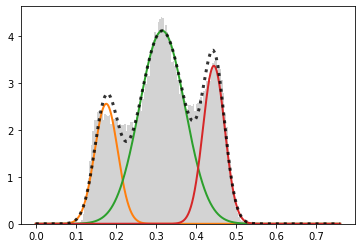

In [25]:
plt.hist(data_flat.ravel(),200,[0,masked_image.max()], density=True, facecolor='lightgray', alpha=1)
for ii in range(n_components):
    plt.plot(x, comps[ii] * comp_weights[ii], lw=2)

plt.plot(my_x, gmm_y_mr1, ':',  color='k', lw=3, label="GMM",  alpha=0.8)

In [26]:
rng = np.random.default_rng()

var_mean_diffs = np.array([0.03, 0.06, 0.08])
p_mu = rng.uniform(-var_mean_diffs, var_mean_diffs)
print(p_mu)

var_std_diffs = np.array([0.012, 0.011, 0.015])
q_sigma = rng.uniform(-var_std_diffs, var_std_diffs)
print(q_sigma)

[ 0.02387576 -0.01020237 -0.0067455 ]
[-0.00273421  0.00030055 -0.01396322]


In [27]:
new_mu = p_mu + mu
new_std = q_sigma + std
print(mu, new_mu)
print(std, new_std)

[0.17591725 0.31573326 0.44479773] [0.19979302 0.30553089 0.43805223]
[0.02880612 0.05694722 0.02720033] [0.02607191 0.05724777 0.01323711]


In [28]:
n_classes = n_components
new_comps = np.zeros(((n_components,) + x.shape))
for k in range(n_classes):
    new_comps[k] = norm.pdf(x, loc=new_mu[k], scale=new_std[k])
    
complete_pdf_new = comp_weights.dot(new_comps)

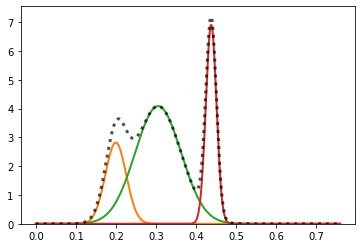

In [29]:
plt.hist(data_flat.ravel(),200,[0,masked_image.max()], density=True, facecolor='lightgray', alpha=0)
for ii in range(n_components):
    plt.plot(x, new_comps[ii] * comp_weights[ii], lw=2)

plt.plot(x, complete_pdf_new, ':',  color='k', lw=3, label="GMM",  alpha=0.7)

The distance from the mean of the Gaussian to some point can be measured as a multiple of the standard deviation, such that:  

$$ \mu - \mathrm{px} = w \sigma $$

This implies that if we know the values of $\sigma$ and $\mu$ we can find the new value of a pixel $\mathrm{px}$:

$$ \mathrm{px} = \mu - w \sigma $$

This $w$ value implicitly informs about the percentile the given pixel belongs to, and so we force the new pixel intensity to lie within the same percentile in the new distribution as in the original distribution.

The last step is to add the three predicted images, by taking into consideration the probability that each pixel belongs to a certain component of the gaussian mixture (probas_original).

In [32]:
n_classes = n_components
w_im = np.zeros(((n_components,) + data_flat.shape))
for k in range(n_classes):
#     data_comp = probas_original[:,k] * data_flat
    w_im[k] = (data_flat.ravel() - mu[k] ) / (std[k]+1e-7)

In [33]:
n_classes = n_components
intensities_im = np.zeros(((n_components,) + data_flat.shape))
for k in range(n_classes):
    intensities_im[k] = new_mu[k] + w_im[k] * new_std[k]

In [34]:
n_classes = n_components
new_image_composed = np.zeros(data_flat.shape)
for k in range(n_classes):
    new_image_composed = new_image_composed +  probas_changed[:,k] * intensities_im[k]

print(new_image_composed.shape)

(1979376,)


In [38]:
# new_image = t1_normalized.copy()
new_image = np.zeros(t1_normalized.shape)
new_image[np.where(masked_image==0)] = t1_normalized[np.where(masked_image==0)]
new_image[np.where(masked_image>0)] = new_image_composed
new_image = normalize_image(new_image, clip_percentiles=False)

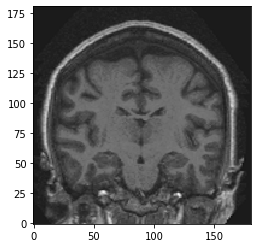

In [39]:
plt.imshow(new_image[:,new_image.shape[1]//2,:].T, cmap="gray", origin="lower", vmin=0, vmax = 1)

0.3205210335255178
0.3103455889196456


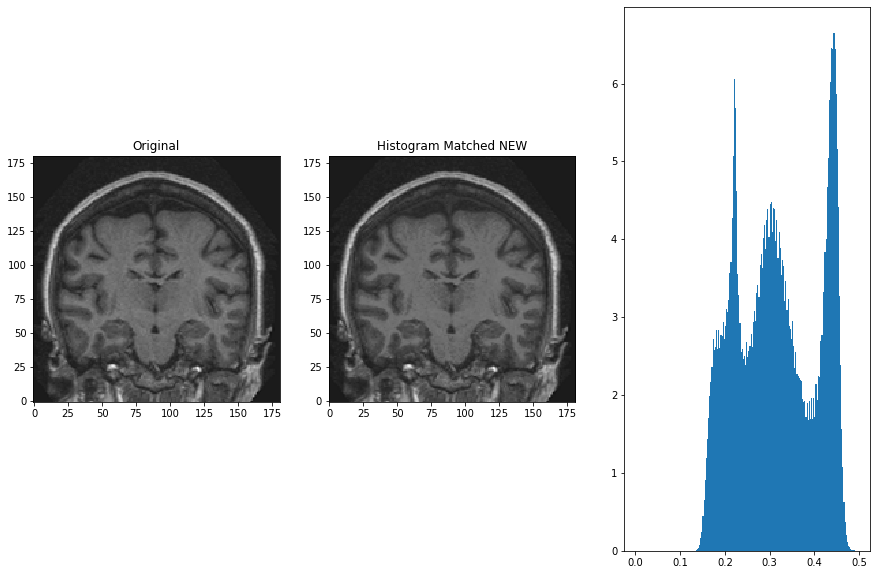

In [40]:
fig, ax = plt.subplots(1,3,figsize=(15,10))



ax[0].imshow(t1_normalized[:,t1_normalized.shape[1]//2,:].T, cmap="gray", origin="lower", vmin=0, vmax = 1)
ax[0].set_title('Original')
# ax[0].plot(130,120, '*', markersize=10 )
print(t1_normalized[130,120, 100])

# ax[1].imshow(imm.T, cmap="gray", origin="lower", vmin=0, vmax = 1.5)
# ax[1].set_title('Histogram Matched (classical)')
ax[1].imshow(new_image[:,new_image.shape[1]//2,:].T, cmap="gray", origin="lower", vmin=0, vmax = 1)
ax[1].set_title('Histogram Matched NEW')
# ax[1].plot(130,120, '*', markersize=10 )
print(new_image[130,120,100])

image_hist = new_image*mask
ax[2].hist(image_hist[image_hist>0].ravel(), 200, [0, 0.5], density=True);

# Using the implementation

In [68]:
from utils.augmentation_utils import generate_gmm_image, normalize_image, fit_gmm
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

In [69]:
t1_path = 'images/T1_neck_stripped_mni.nii.gz'
mask_path = 'images/brain_mask_mni.nii.gz'

#### Load the images and get the data

t1 = nib.load(t1_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

current_image = t1


In [70]:
t1_normalized = normalize_image(current_image, clip_percentiles=False, pmin=0.1, pmax=99.9)


In [71]:
masked_image = t1_normalized * mask
data = masked_image[masked_image > 0]
x = np.expand_dims(data, 1)

In [74]:
new_image = generate_gmm_image(t1_normalized, mask=mask, n_components=3, 
                               std_means=(0.03, 0.06, 0.08), std_sigma=[0.012, 0.011, 0.015],
                               p_mu=None, q_sigma=None,  normalize=False, percentiles=True)

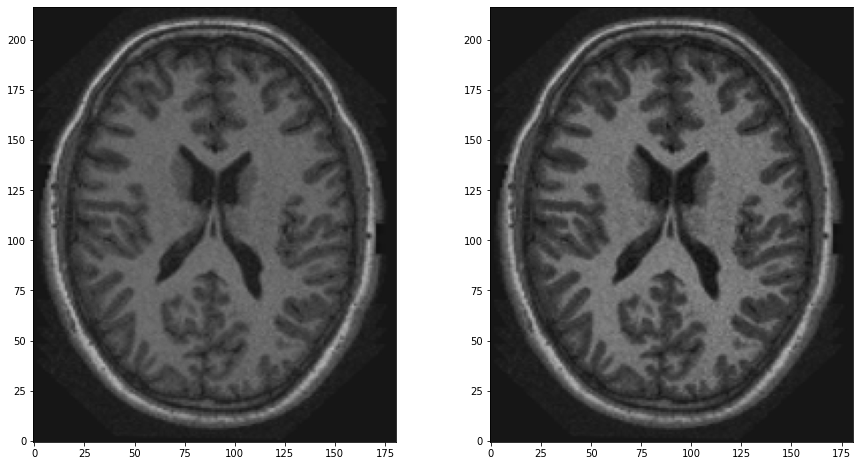

In [75]:
fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].imshow(t1_normalized[:,:,int(np.shape(t1_normalized)[2]/2)].T, origin='lower', cmap='gray', vmin=0, vmax = 1)
ax[1].imshow(new_image[:,:,int(np.shape(new_image)[2]/2)].T, origin='lower', cmap='gray', vmin=0, vmax =1)

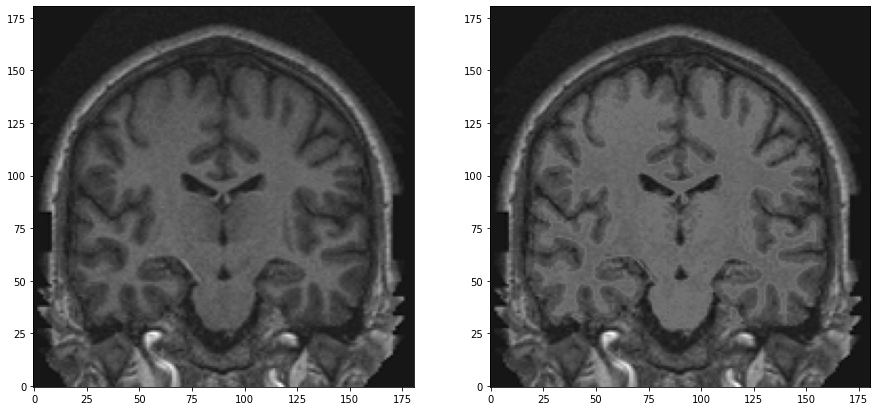

In [47]:
fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].imshow(t1_normalized[:,int(np.shape(t1_normalized)[1]/2),:].T, origin='lower', cmap='gray', vmin=0, vmax = 1)
ax[1].imshow(new_image[:,int(np.shape(t1_normalized)[1]/2), :].T, origin='lower', cmap='gray', vmin=0, vmax =1)